In [1]:
import torch
from torch import nn
import torchvision.datasets as datasets 
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

## Loading the dataset and viewing samples

In [2]:
training_data = datasets.MNIST(root='data', download=True, train=True, transform=ToTensor())
testing_data = datasets.MNIST(root='data', download=True, train=False, transform=ToTensor())

training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
testing_loader = DataLoader(testing_data, batch_size=64, shuffle=True)

Displaying a few sample images

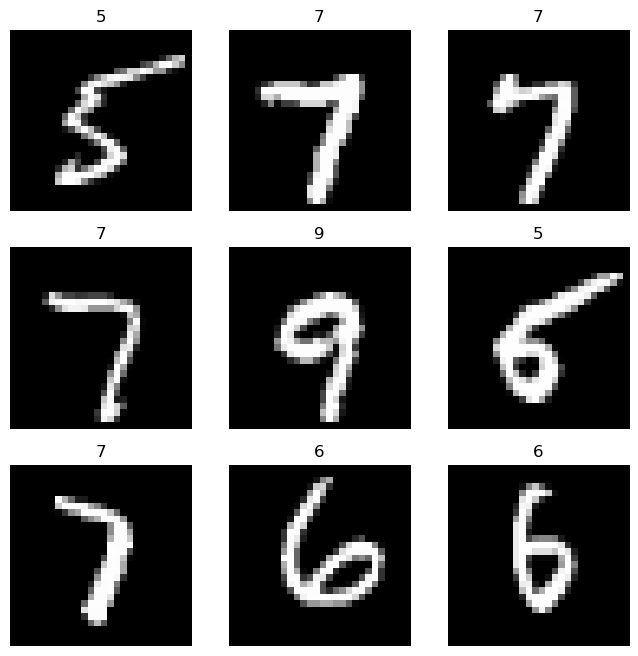

In [3]:
figure = plt.figure(figsize = (8,8))
rows, cols = 3, 3

for i in range(1, cols*rows+1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")

## Classes and functions

In [4]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")    
    

In [5]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [18]:
device = (    
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
  )

In [6]:
class LinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    pixel_size = 784
    # transforms each 2D (28x28) image into an array of 784 pixel values
    self.flatten = nn.Flatten()
    # nn.Sequential is an ordered container of modules
    self.linear_stack = nn.Sequential(
      nn.Linear(pixel_size, 128, bias=False),
      nn.Linear(128, 32, bias=False),
      nn.Linear(32, 10, bias=False)
    )
  
  def forward(self, x):
    x = self.flatten(x) # flatten inputs
    prediction = self.linear_stack(x) # make prediction
    return prediction

In [30]:
class NonLinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    pixel_size = 784
    # transforms each 2D (28x28) image into an array of 784 pixel values
    self.flatten = nn.Flatten()
    # nn.Sequential is an ordered container of modules
    self.linear_stack = nn.Sequential(
      nn.Linear(pixel_size, 1024, bias=False),
      nn.ELU(),
      nn.Linear(1024, 1024, bias=False),
      nn.ELU(),
      nn.Linear(1024, 1024, bias=False),
      nn.ELU(),
      nn.Linear(1024, 1024, bias=False),
      nn.ELU(),
      nn.Linear(1024, 10, bias=False),
      # nn.Softmax()
    )
  
  def forward(self, x):
    x = self.flatten(x) # flatten inputs
    prediction = self.linear_stack(x) # make prediction
    return prediction
  
non_linear_model = NonLinearModel().to(device)

## Making predictions before training

Getting a random sample

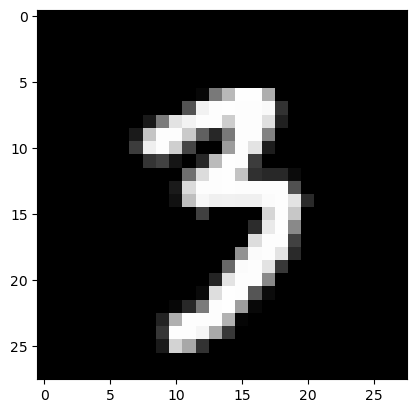

In [9]:
sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]
plt.imshow(img.squeeze(), cmap="gray")

Linear model prediction

In [10]:
model = LinearModel().to(device)

output = model(img)
pred_probab = nn.Softmax(dim=1)(output)
y_pred = pred_probab.argmax(1)
print("Prediction: ", y_pred)
print("Actual: ",label)

Prediction:  tensor([3])
Actual:  3


In [11]:
output = non_linear_model(img)
pred_probab = nn.Softmax(dim=1)(output)
y_pred = pred_probab.argmax(1)
print("Prediction: ", y_pred)
print("Actual: ",label)

Prediction:  tensor([7])
Actual:  3


In [12]:
linear_accuracy = 0
non_linear_accuracy = 0

for i in range(0, 50):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  output = model(img)
  pred_probab = nn.Softmax(dim=1)(output)
  y_pred = pred_probab.argmax(1)
  if y_pred == label:
    linear_accuracy += 1

  output = non_linear_model(img)
  pred_probab = nn.Softmax(dim=1)(output)
  y_pred = pred_probab.argmax(1)
  if y_pred == label:
    non_linear_accuracy += 1

print("Linear Accuracy: ", linear_accuracy)
print("Non Linear Accuracy: ", non_linear_accuracy)

Linear Accuracy:  7
Non Linear Accuracy:  7


## Training loop (linear model)

In [13]:
# Linear model
optimizer = torch.optim.SGD(model.parameters(), lr=0.002)
loss_fn = nn.CrossEntropyLoss()

epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(training_loader, model, loss_fn, optimizer)
  test(testing_loader, model, loss_fn)
print("Done!")

# torch.save(model.state_dict(), "model.pth")
# print("Saved PyTorch Model State to model.pth")

Epoch 1
-------------------------------
loss: 2.296011  [    0/60000]
loss: 2.260624  [ 6400/60000]
loss: 2.218465  [12800/60000]
loss: 2.189862  [19200/60000]
loss: 2.205851  [25600/60000]
loss: 2.130568  [32000/60000]
loss: 2.093788  [38400/60000]
loss: 2.089091  [44800/60000]
loss: 2.084116  [51200/60000]
loss: 1.959549  [57600/60000]
Test Error: 
 Accuracy: 63.8%, Avg loss: 1.941330 

Epoch 2
-------------------------------
loss: 1.942573  [    0/60000]
loss: 1.901540  [ 6400/60000]
loss: 1.899248  [12800/60000]
loss: 1.746531  [19200/60000]
loss: 1.688149  [25600/60000]
loss: 1.599377  [32000/60000]
loss: 1.608367  [38400/60000]
loss: 1.438438  [44800/60000]
loss: 1.487192  [51200/60000]
loss: 1.396200  [57600/60000]
Test Error: 
 Accuracy: 72.6%, Avg loss: 1.302625 

Epoch 3
-------------------------------
loss: 1.271851  [    0/60000]
loss: 1.135883  [ 6400/60000]
loss: 1.128596  [12800/60000]
loss: 0.989964  [19200/60000]
loss: 1.280175  [25600/60000]
loss: 0.967882  [32000/600

## Training loop (non-linear model)

In [31]:
# non-linear model
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
loss_fn = nn.CrossEntropyLoss()

epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(training_loader, non_linear_model, loss_fn, optimizer)
  test(testing_loader, non_linear_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301088  [    0/60000]
loss: 2.299836  [ 6400/60000]
loss: 2.301845  [12800/60000]
loss: 2.300352  [19200/60000]
loss: 2.303452  [25600/60000]
loss: 2.302814  [32000/60000]
loss: 2.301275  [38400/60000]
loss: 2.301409  [44800/60000]
loss: 2.302829  [51200/60000]
loss: 2.300719  [57600/60000]
Test Error: 
 Accuracy: 11.5%, Avg loss: 2.300299 

Epoch 2
-------------------------------
loss: 2.298277  [    0/60000]
loss: 2.304820  [ 6400/60000]
loss: 2.302580  [12800/60000]
loss: 2.297211  [19200/60000]
loss: 2.304224  [25600/60000]
loss: 2.304353  [32000/60000]
loss: 2.303557  [38400/60000]


KeyboardInterrupt: 